
# Video Classification using an LSTM

In [0]:
%matplotlib inline

This allows the plots generated by matplotlib (and seaborn) to show inline in the notebook. This is useful to view plots easily from the jupyter notebook itself

In [0]:
# global imports

import os
import sys
import cv2
import glob
import pickle
import argparse
import numpy as np
import matplotlib.pyplot as plt

from os import path

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score

Using TensorFlow backend.


In [0]:
# Upload data.zip file from this week's courseworks folder to Google Drive.  (takes 10-15 mins)
# "Mount" the drive and then unzip it using the following code.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Example from My Google Drive path.  Puts unzipped data.zip files in colab /content/ directory
! unzip '/content/drive/My Drive/Projects in Advanced Machine Learning/Week 11/data.zip'

We import all the libraries we would need later. The purposes of each library/function are explained wherever they are used

In [0]:
# defining some global variables

PATH = path.abspath(path.join(os.getcwd(), ".."))

dataset_name = "ucf101"

DATA_PATH = path.join(PATH, "content/data/{}".format(dataset_name))


This defines global paths that allow us to read data files and store/load saved models. The assert statements ensure if the corresponding paths exist on the file system or not


In [0]:
# add root directory to system path

sys.path.append(PATH)

This would allow us to use the shareai api in the root directory

In [0]:
# initialize the set of labels from the speech dataset we are going to train our network
# on

# initialize the set of labels from the spots activity dataset we are
# going to train our network on

CLASSES = ["horserace", "kayaking", "pullups"]

for cl in CLASSES:
    assert path.exists(path.join(DATA_PATH, cl)), f"Path does not exist for class {cl}"

This defines the list of classes that we have in our dataset. This is primarily just used to reading data files. The assert statements ensure we have all classes in our data directory

## Reading Data

In [0]:
vidcaps = dict()

for cl in CLASSES:
    # loop over the image paths
    video_paths = glob.glob(path.join(DATA_PATH, cl, "*"))

    vidcaps[cl] = [cv2.VideoCapture(video) for video in video_paths[:30]]

In [0]:
print(vidcaps.keys())
print(len(vidcaps['horserace']))
print(vidcaps['horserace'][0])


dict_keys(['horserace', 'kayaking', 'pullups'])
30
<VideoCapture 0x7f666a29f590>


For each class, we read the filenames of all files in that class directory and load them using (opencv)[https://opencv.org/], which is a popular library for manipulating image files. We will use this library for all feature extraction steps throughout the tutorial

To speed up the training, we only use 30 videos for each class

## Visualizing the Dataset

In [0]:
counts = [len(vidcaps[c]) for c in CLASSES]

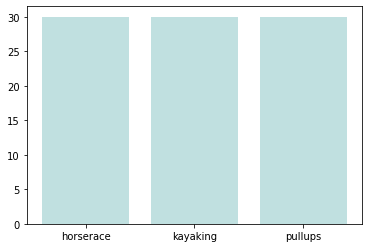

In [0]:
plt.bar(CLASSES, counts, color="#c0e0e0")
plt.show()

This helps us visualize if there is any form of class imbalance. Since we fixed the number of videos per class to be 30, this is what the plot shows

In [0]:
success, frame=vidcaps['horserace'][0].read()
print(success)
print(frame) #image data for video frame here

True
[[[ 3 13  0]
  [ 3 13  0]
  [ 4 14  0]
  ...
  [ 1  9  0]
  [ 4 12  2]
  [ 0  6  0]]

 [[ 1 11  0]
  [ 3 13  0]
  [ 3 13  0]
  ...
  [ 1  9  0]
  [ 4 12  2]
  [ 0  5  0]]

 [[ 0 10  0]
  [ 1 11  0]
  [ 3 13  0]
  ...
  [ 0 10  0]
  [ 3 11  1]
  [ 0  4  0]]

 ...

 [[ 2 11  5]
  [ 0  0  0]
  [ 6 15  9]
  ...
  [ 0 13  2]
  [ 0 10  0]
  [ 0  6  0]]

 [[ 2 11  5]
  [ 0  0  0]
  [ 6 15  9]
  ...
  [ 0 18  4]
  [ 2 14  1]
  [ 0  6  0]]

 [[ 2 11  5]
  [ 0  0  0]
  [ 6 15  9]
  ...
  [ 0 19  5]
  [ 4 16  3]
  [ 0  6  0]]]


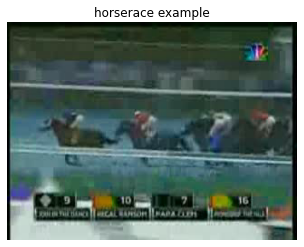

In [0]:
# Visualize image from frame
plt.imshow(frame)

plt.title("horserace example")
plt.axis("off")

plt.show()

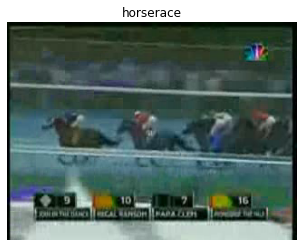

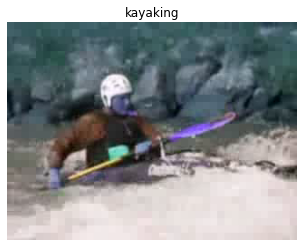

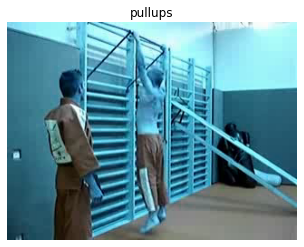

In [0]:
# load the video captures

for cl, v in vidcaps.items():
    success, frame = v[0].read()

    plt.imshow(frame)

    plt.title(cl)
    plt.axis("off")

    plt.show()

The above three images just show the the first frame for one of the samples within each class without any sort of preprocessing

## Data Preparation for Learning

### Preprocess X and y data 
Preprocess the data to extract frames out of each video and resize them to a fixed size of (128x128) pixels. Then flatten images to act as features for each time step. We also set the number of frames to extract per video (defaulting to 60)

In [0]:
def preprocess(
    vidcaps, labels, one_hot_enc=None, num_frames=60, gap_frames=3, **kwargs
):
    """
    This function preprocesses the data to extract frames out of each video and resize
    them to a fixed size of (128x128) pixels. Moreover, these images are flattened out to
    act as features for each time step.
    
    params:
        vidcaps
            list of VideoCapture objects from opencv to be processed
        
        labels
            list of labels which will be encoded using label_encoder
        
        one_hot_enc
            object that has a method transform which transforms list of labels to their
            one hot encoded form
            
        num_frames
            the number of frames to be extracted from each video. If there aren't
            sufficient frames, then the list is padded with zeros
            
        gap_frames:
            the number of frames after which we extract the next frame. If =1,
            contiguous frames are extracted
            
    returns:
        X
            list of transformed features corresponding to data passed as input
        
        y
            list of one-hot encoded labels
    
    """
    if one_hot_enc is None:
        raise ValueError("one_hot_enc cannot be None")

    # we use transfer learning to extract features from each image frame
    # pretrained vgg16 is used to extract these features which is imported from keras

    import cv2
    import numpy as np

    from keras.applications import vgg16
    from keras.preprocessing import sequence

    # convert all labels to one-hot encoding
    y = np.array([[l] for l in labels])
    y = one_hot_enc.transform(y).toarray()

    # initialize the vgg model
    vgg_model = vgg16.VGG16(weights="imagenet")

    X = []
    for vidcap in vidcaps:
        frames = []

        success, frame = vidcap.read()
        idx = 0

        while success:
            # for each frame, do if we satisfy the gap_frames parameter
            if idx % gap_frames == 0:
                # convert to RGB (default cv2 is BGR)
                # this is important because the vgg model is trained on RGB images
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, (128, 128))

                # extract features for the resized image
                frame = vgg16.preprocess_input(frame)

                # flatten the features and append to a list of features for this video
                frame = frame.reshape(-1)

                frames.append(frame)

                if len(frames) >= num_frames:
                    break

            idx += 1
            success, frame = vidcap.read()

        if len(frames) == 0:
            continue

        # if number of timesteps or frames < num_frames, pad
        while len(frames) < num_frames:
            frames.append(np.zeros(*frames[-1].shape))

        frames = np.array(frames, dtype=np.float)

        X.append(frames)

    return X, y

### Creating the Preprocessor

In [0]:
# define the one-hot encoder

enc = OneHotEncoder(handle_unknown="ignore")
enc.fit(np.array([[cl] for cl in CLASSES]))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=True)

Creating the one-hot encoder to convert prediction classes into one-hot encoded variables

### Preprocessing the Data

The zip function when passed in this manner separates the list of lists into separate lists

In [0]:
# load and preprocess the data

X = []
y = []

for cl in CLASSES:
    features = []

    print(f"Extracting features for class {cl}")

    cl_labels = [cl] * len(vidcaps[cl])

    cl_data, cl_labels = preprocess(vidcaps[cl], cl_labels,enc)

    X.extend(cl_data)
    y.extend(cl_labels)
    
    del features

Extracting features for class horserace
Extracting features for class kayaking
Extracting features for class pullups


In [0]:
# 90 observations
print(len(X))
print(len(y))


90
90


In [0]:
# convert the data and labels to NumPy arrays

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int)



In [0]:
print(y.shape)
print(X.shape) # X has 60 frames per time step and 49152 x input variables per time step


(90, 3)
(90, 60, 49152)


### Defining Train and Test Data

In [0]:
# Timesteps are defined per observation, so we can train test split an shuffle without
# losing sequential information for validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True
)

Split data into train/test data with a 70-30 split

## Learning and Predicting

### Defining the model

In [0]:
# Load libraries

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import LSTM,Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop


# defining the model

hidden_size = 50

dense_out_1 = 20
dense_out_2 = len(CLASSES)

model = Sequential()
model.add(LSTM(hidden_size))
model.add(Dense(dense_out_1, activation="relu"))
model.add(Dense(dense_out_2, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

### Learning the network

In [0]:
# fitting the network (This takes about a minute per epoch). Output indicates we should consider slowing down learning process with Dropout.

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  history = model.fit(
      X_train,
      y_train,
      epochs=25,
      batch_size=1,
      validation_data=(X_test, y_test),
      verbose=2,
      shuffle=True,
  )

Epoch 1/25
63/63 - 61s - loss: 1.0720 - accuracy: 0.5238 - val_loss: 0.8864 - val_accuracy: 0.8148
Epoch 2/25
63/63 - 59s - loss: 0.9958 - accuracy: 0.6508 - val_loss: 0.8718 - val_accuracy: 0.7778
Epoch 3/25
63/63 - 59s - loss: 0.8468 - accuracy: 0.7460 - val_loss: 0.7068 - val_accuracy: 0.7778
Epoch 4/25
63/63 - 62s - loss: 0.6534 - accuracy: 0.8254 - val_loss: 0.5984 - val_accuracy: 0.7778
Epoch 5/25
63/63 - 59s - loss: 0.5386 - accuracy: 0.8571 - val_loss: 0.5544 - val_accuracy: 0.7407
Epoch 6/25
63/63 - 59s - loss: 0.4487 - accuracy: 0.8571 - val_loss: 0.5097 - val_accuracy: 0.7778
Epoch 7/25
63/63 - 60s - loss: 0.4050 - accuracy: 0.8571 - val_loss: 0.6470 - val_accuracy: 0.7037
Epoch 8/25
63/63 - 61s - loss: 0.3789 - accuracy: 0.8730 - val_loss: 0.5172 - val_accuracy: 0.7778
Epoch 9/25
63/63 - 61s - loss: 0.3761 - accuracy: 0.8571 - val_loss: 0.5285 - val_accuracy: 0.7407
Epoch 10/25
63/63 - 61s - loss: 0.3173 - accuracy: 0.9048 - val_loss: 0.5380 - val_accuracy: 0.7407
Epoch 11/

This trains the model. For each sample, the LSTM is run on all the time steps and the final classification is done using the hidden state of the last step. Then the loss is back-propogated over the complete cycle. 

The fit function also returns the list of training and test losses we see over time and this is recorded in the `history` variable. We plot these losses in the next cell in order to confirm if the training went as we would expect.

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  9840600   
_________________________________________________________________
dense (Dense)                multiple                  1020      
_________________________________________________________________
dense_1 (Dense)              multiple                  63        
Total params: 9,841,683
Trainable params: 9,841,683
Non-trainable params: 0
_________________________________________________________________


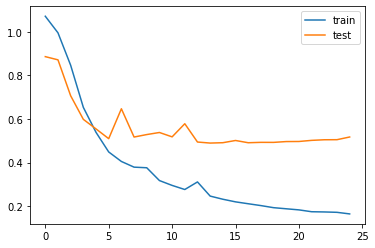

In [0]:
# plotting the training and test lloss

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.show()

In [0]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 1ms/step - loss: 0.5173 - accuracy: 0.7407


[0.5173492431640625, 0.7407407164573669]

In [0]:
model.predict(X_test)[1] # predicts second test image is horseracing (one hot data first class column has greatest softmax value)

array([0.90748817, 0.00969991, 0.08281196], dtype=float32)

In [0]:
y_test[1] # Correct!

array([1, 0, 0])